W tym zadaniu zapoznamy się z inną metodą klasteryzacji, czyli grupowaniem hierarchicznym. Będziemy zajmować się metoda deaglomeracyjną.

Zacznijmy od jej przeciwieństwa, czyli metody aglomeracyjnej. Metoda aglomeracyjna polega na tym, że początkowo każdy obiekt tworzy osobny klaster (skupienie). Następnie dwa najbliższe skupienia (pod względem wybranej metryki odległości) scalane są w jeden klaser i taka operacja jest powtarzana do momentu, aż powstanie jedno duże skupienie zawierające wszystkie dane. 

Metoda deaglomeracyjna polega na przeciwnym postępowaniu - najpierw wszystkie obiekty znajdują się w jednym skupieniu, a następnie dzielimy je na mniejsze zawierające najbardziej podobne do siebie obiekty, aż dojdziemy do momentu, gdy w każdym skupieniu znajduje się tylko jeden obiekt. Wynik takiego podziału przedstawia się w postaci tzw. dendrogramu - wykresu, który przedstawia hierarchię skupień (przykładowy dendrogram znajduje się w dalejszej części zadania).

Dendrogram może zostać "przycięty" na wybranej wysokości. W tym celu wybieramy liczbę poziomów, które chcemy przedstawić na wykresie (licząc od góry, czyli od największego skupienia). Pod wykresem można podpisać, ile obiektów znajduje się w każdym skupieniu.

In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [37]:
feats_col_list = [0,1,2,3,4,5,6,7,8]
feats_df = pd.read_csv("fma_metadata/echonest.csv", usecols=feats_col_list, low_memory=False, header=2) 
feats_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
feats_df. dropna(inplace=True)
feats_df.reset_index(drop = True, inplace=True)

genre_col_list = [0,40]
genre_df = pd.read_csv("fma_metadata/tracks.csv", usecols=genre_col_list, low_memory=False, header=1)
genre_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
genre_df.dropna(inplace=True)
genre_df.reset_index(drop = True, inplace=True)

labels_dict = {value: index for index, value in enumerate(genre_df["genre_top"].unique())}
genre_df['genre_numeric_label'] = [labels_dict[genre_df["genre_top"][i]]for i in genre_df.index]

all_data_df = pd.merge(feats_df, genre_df, on='track_id')

feats_names = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo", "valence"]

In [38]:
from sklearn.preprocessing import StandardScaler

scaled_feats = StandardScaler().fit_transform(all_data_df[feats_names])

Do narysowania dendrogramu użyjemy funkcji z dokumentacji biblioteki scikit-learn:
https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

(9354, 2)


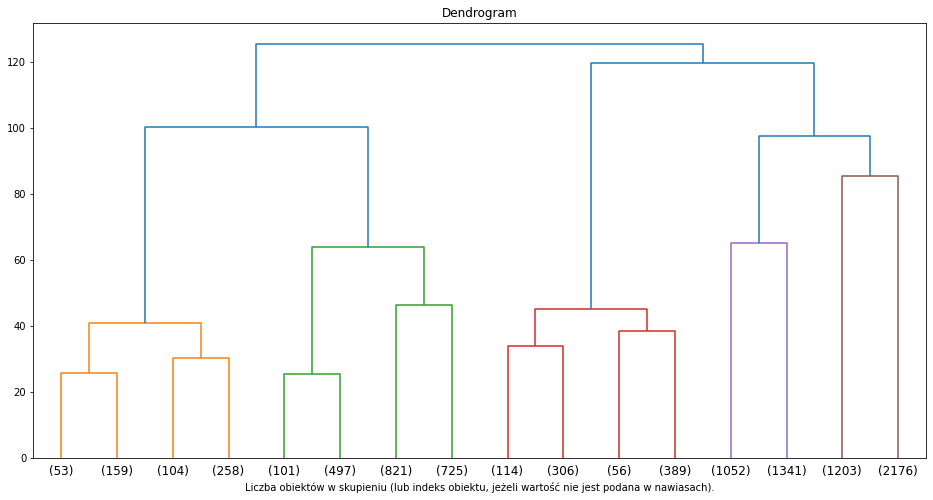

In [39]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # zliczanie obiektów w poszczególnych skupieniach
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    print(model.children_.shape)

    # rysowanie dendrogramu
    dendrogram(linkage_matrix, **kwargs)

    
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
#affinity - metryka, króra będzie użyta do obliczenia odległości między obiektami
#distance_threshold=0, n_clusters=None zapewniają podział do momentu, aż w każdym skupieniu będzie znajdował się 
#tylko 1 obiekt
#linkage - metoda tworzenia skupień

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1) 
model = model.fit(scaled_feats)
ax.set_title("Dendrogram")

# wyświetlimy trzy poziomy dendrogramu
dn = plot_dendrogram(model, truncate_mode="level", p=3, labels=all_data_df['genre_numeric_label']) 
#p - liczba poziomów, na które będą podzielone dane na wyświetlanym wykresie

ax.set_xlabel("Liczba obiektów w skupieniu (lub indeks obiektu, jeżeli wartość nie jest podana w nawiasach).")
plt.show()

Metoda aglomeracyjna może też zwrócić przyporządkowanie do skupień. Żeby je uzyskać, należy użyć poniższego kodu:

In [40]:
model = AgglomerativeClustering(n_clusters=16, affinity='euclidean') 
#n_clusters - liczba skupień, na które chcemy podzielić dane

clusters = model.fit_predict(scaled_feats)

W zmiennej clusters są zapisane numery skupień, do których przyporządkowane są obiekty. Żeby sprawdzić, czy podział na gatunki muzyczne pokrywa się z tymc co wyszło z analizy aglomeracyjnej, najlepiej będzie dodać obie rzeczy do nowego DataFrame'a:

In [41]:
dendrogram_clusters_df = pd.DataFrame()
dendrogram_clusters_df['track_id'] = all_data_df["track_id"]
dendrogram_clusters_df['real genre'] = all_data_df["genre_top"]
dendrogram_clusters_df['dendrogram clusters'] = clusters

Teraz możemy zastosować filtrację po gatunkach muzycznych i wyświetlić, do ilu skupień zostały przyporządkowane utwory tego gatunku. Poniżej przykład dla muzyki klasycznej.

In [42]:
#Wyświetlamy fragment DataFrame'a z muzyką klasyczną. W pierwszej kolumnie wyświetli się indeks wiersza, 
#w trzeciej gatunek, a w czwartej nr skupienia
dendrogram_clusters_df.loc[dendrogram_clusters_df['real genre'] == 'Classical'].head(10) #wyświtlamy pierwsze 10 wierszy
#loc użyte na DataFrame spowoduje zlokaizowanie i wyświetlenie tych wierszy, które spełniają zadany warunek

,track_id,real genre,dendrogram clusters
1568,4850,Classical,10
1569,4851,Classical,10
2172,10026,Classical,5
2173,10027,Classical,10
2174,10028,Classical,5
2175,10029,Classical,10
2176,10030,Classical,10
2177,10031,Classical,4
2178,10033,Classical,7
2179,10035,Classical,7


In [43]:
#sprawdzamy, jakie numery skupień pojawiają się dla utworów klasycznych
dendrogram_clusters_df.loc[dendrogram_clusters_df['real genre'] == 'Classical']['dendrogram clusters'].unique()

array([10,  5,  4,  7, 14,  9,  2], dtype=int64)

Przeprowadź analogiczną analizę tworząc tylko 4 skupienia ze wszystkich obiektów (zmodyfikuj linijkę, w której tworzony jest model). Sprawdź, do jakich skupień zostały przyporządkowane utwory z wybranego gatunku.

['Hip-Hop' 'Pop' 'Folk' 'Jazz' 'Rock' 'Electronic' 'International' 'Blues'
 'Classical' 'Old-Time / Historic' 'Instrumental' 'Experimental']
(9354, 2)


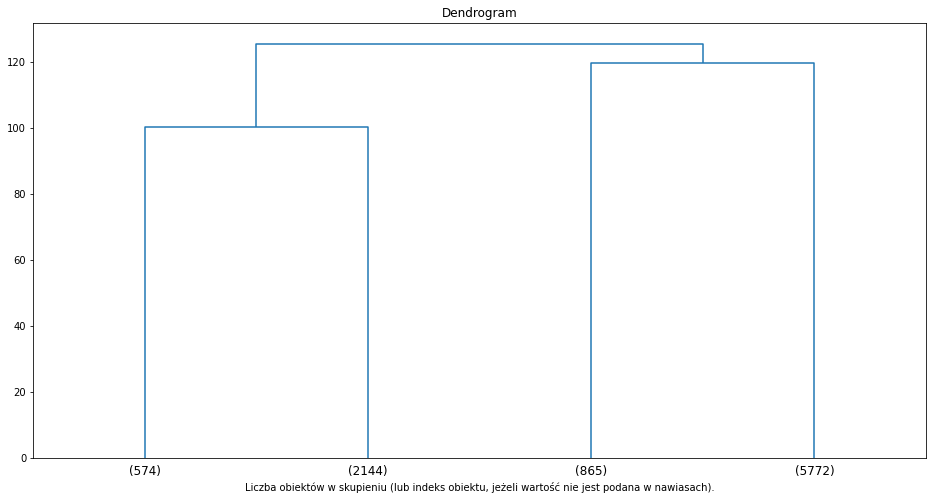

array([0, 1, 2, 3], dtype=int64)

In [44]:
#dla ułatwienia wyświetlamy listę gatunków muzycznych, które są w bazie - wybierz jeden spośród nich
print(all_data_df["genre_top"].unique())

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
#affinity - metryka, króra będzie użyta do obliczenia odległości między obiektami
#distance_threshold=0, n_clusters=None zapewniają podział do momentu, aż w każdym skupieniu będzie znajdował się 
#tylko 1 obiekt
#linkage - metoda tworzenia skupień

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1) 
model = model.fit(scaled_feats)
ax.set_title("Dendrogram")

# wyświetlimy trzy poziomy dendrogramu
dn = plot_dendrogram(model, truncate_mode="level", p=1, labels=all_data_df['genre_numeric_label']) 
#p - liczba poziomów, na które będą podzielone dane na wyświetlanym wykresie

ax.set_xlabel("Liczba obiektów w skupieniu (lub indeks obiektu, jeżeli wartość nie jest podana w nawiasach).")
plt.show()

model = AgglomerativeClustering(n_clusters=4, affinity='euclidean') 
#n_clusters - liczba skupień, na które chcemy podzielić dane

clusters = model.fit_predict(scaled_feats)

dendrogram_clusters_df = pd.DataFrame()
dendrogram_clusters_df['track_id'] = all_data_df["track_id"]
dendrogram_clusters_df['real genre'] = all_data_df["genre_top"]
dendrogram_clusters_df['dendrogram clusters'] = clusters

dendrogram_clusters_df.loc[dendrogram_clusters_df['real genre'] == 'Rock']['dendrogram clusters'].unique()

Teraz przeprowadź odwrotną analizę - sprawdź, jakie gatunki zostały przyporządkowane do każdego z 4 skupień. Spróbuj wyznaczyć liczbę utworów każdego gatunku, które zostały przyporządkowane do tych skupień. Czy zostały podzielone mniej więcej równomiernie, czy większość utworów danego gatunku znajduje się w tym samym skupieniu?

In [45]:
[print(dendrogram_clusters_df.loc[dendrogram_clusters_df['dendrogram clusters']==x]['real genre'].unique()) for x in dendrogram_clusters_df['dendrogram clusters'].unique()]

['Hip-Hop' 'Rock' 'Folk' 'Electronic' 'Jazz' 'Blues' 'Pop'
 'Old-Time / Historic' 'International' 'Instrumental' 'Experimental'
 'Classical']
['Hip-Hop' 'Pop' 'Folk' 'Jazz' 'Rock' 'Electronic' 'International' 'Blues'
 'Old-Time / Historic' 'Classical' 'Instrumental' 'Experimental']
['Folk' 'Rock' 'Pop' 'Jazz' 'Electronic' 'Hip-Hop' 'Blues' 'International'
 'Classical' 'Old-Time / Historic' 'Instrumental' 'Experimental']
['Rock' 'Folk' 'Electronic' 'Pop' 'Jazz' 'Hip-Hop' 'Old-Time / Historic'
 'International' 'Classical' 'Instrumental' 'Blues']


[None, None, None, None]

Sprawdź, jak na wyniki wpłynie zmiana metryki odległości na inną niż euklidesowa i zmiana metody tworzenia skupień na inną niż metoda Warda. Do wyboru są:
- metryki (affinity): “euclidean”, “l1”, “l2”, “manhattan”, “cosine”
- metody (linkage): ‘ward’, ‘complete’, ‘average’, ‘single’

Uwaga: używając metody Warda trzeba użyć metryki euklidesowej, inaczej nie zadziała.

(9354, 2)


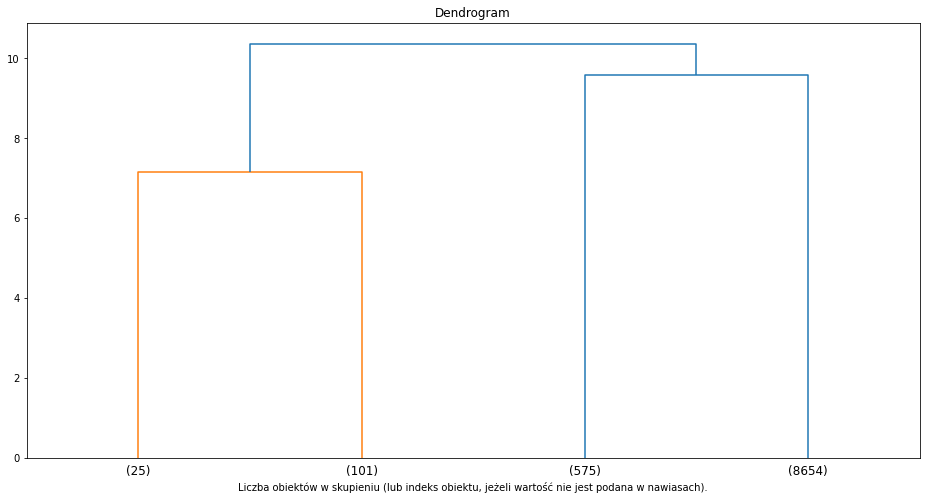

array([0, 1, 2, 3], dtype=int64)

In [56]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
#affinity - metryka, króra będzie użyta do obliczenia odległości między obiektami
#distance_threshold=0, n_clusters=None zapewniają podział do momentu, aż w każdym skupieniu będzie znajdował się 
#tylko 1 obiekt
#linkage - metoda tworzenia skupień

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1) 
model = model.fit(scaled_feats)
ax.set_title("Dendrogram")

# wyświetlimy trzy poziomy dendrogramu
dn = plot_dendrogram(model, truncate_mode="level", p=1, labels=all_data_df['genre_numeric_label']) 
#p - liczba poziomów, na które będą podzielone dane na wyświetlanym wykresie

ax.set_xlabel("Liczba obiektów w skupieniu (lub indeks obiektu, jeżeli wartość nie jest podana w nawiasach).")
plt.show()

model = AgglomerativeClustering(n_clusters=4, affinity='euclidean') 
#n_clusters - liczba skupień, na które chcemy podzielić dane

clusters = model.fit_predict(scaled_feats)

dendrogram_clusters_df = pd.DataFrame()
dendrogram_clusters_df['track_id'] = all_data_df["track_id"]
dendrogram_clusters_df['real genre'] = all_data_df["genre_top"]
dendrogram_clusters_df['dendrogram clusters'] = clusters

dendrogram_clusters_df.loc[dendrogram_clusters_df['real genre'] == 'Rock']['dendrogram clusters'].unique()

In [57]:
[print(dendrogram_clusters_df.loc[dendrogram_clusters_df['dendrogram clusters']==x]['real genre'].unique()) for x in dendrogram_clusters_df['dendrogram clusters'].unique()]

['Hip-Hop' 'Rock' 'Folk' 'Electronic' 'Jazz' 'Blues' 'Pop'
 'Old-Time / Historic' 'International' 'Instrumental' 'Experimental'
 'Classical']
['Hip-Hop' 'Pop' 'Folk' 'Jazz' 'Rock' 'Electronic' 'International' 'Blues'
 'Old-Time / Historic' 'Classical' 'Instrumental' 'Experimental']
['Folk' 'Rock' 'Pop' 'Jazz' 'Electronic' 'Hip-Hop' 'Blues' 'International'
 'Classical' 'Old-Time / Historic' 'Instrumental' 'Experimental']
['Rock' 'Folk' 'Electronic' 'Pop' 'Jazz' 'Hip-Hop' 'Old-Time / Historic'
 'International' 'Classical' 'Instrumental' 'Blues']


[None, None, None, None]